# 📑 &nbsp; Deep Learning. P5: Decor Recognition & Colorization
<a href="https://olgabelitskaya.github.io/README.html">&#x1F300; &nbsp; Home Page &nbsp; &nbsp; &nbsp;</a> 
<a href="https://www.instagram.com/olga.belitskaya/">&#x1F300; &nbsp; Instagram Posts &nbsp; &nbsp; &nbsp;</a>
<a href="https://www.pinterest.ru/olga_belitskaya/code-style/">&#x1F300; &nbsp; Pinterest Posts</a><br/>

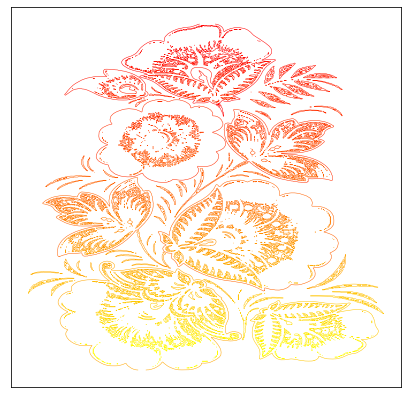

In [1]:
import pylab; from skimage import io,color,measure
def vector(file,cm,level=.75):
    path1='https://olgabelitskaya.github.io/'
    path2='pattern0%s'%(file)+'.jpeg'
    img=io.imread(path1+path2); level=level
    gray_img=color.colorconv.rgb2grey(img) 
    contours=measure.find_contours(gray_img,level)
    n=len(contours)
    pylab.figure(figsize=(int(7),int(7)))
    pylab.gca().invert_yaxis()
    [pylab.plot(contours[i][:,int(1)],
                contours[i][:,int(0)],lw=.5,
                color=pylab.get_cmap(cm)(i/n)) 
     for i in range(n)]
    pylab.xticks([]); pylab.yticks([]); pylab.show()
vector(1,'autumn')    

## ✒️ &nbsp;Step 0. Import Libraries

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import h5py,urllib,zipfile
import pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from skimage.transform import resize
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 1.15.2


In [0]:
fw='weights.decor.hdf5'
dr2,dr25,dr3,dr5=\
float(.2),float(.25),float(.3),float(.5)
fr,al=float(.5),float(.02)
[i0,i1,i2,i3,i4,i5,i6]=\
[int(0),int(1),int(2),int(3),int(4),int(5),int(6)]
[i7,i8,i10,i11,i12,i16]=\
[int(7),int(8),int(10),int(11),int(12),int(16)]
[i20,i32,i48,i50,i64,i96]=\
[int(20),int(32),int(48),int(50),int(64),int(96)]
[i100,i128,i150,i196,i200]=\
[int(100),int(128),int(150),int(196),int(200)]
[i256,i512,i1024,i2048]=\
[int(256),int(512),int(1024),int(2048)]

In [0]:
def ohe(x): 
    return OneHotEncoder(categories='auto')\
           .fit(x.reshape(-i1,i1))\
           .transform(x.reshape(-i1,i1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=float(.2),
                     random_state=i1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def resh(x,n):
    y=[resize(el,(n,n,i3),
              anti_aliasing=True) for el in x]
    return np.array(y)
def gresh(x,n): 
    y=np.array([resize(el,(n,n,i1),
                       anti_aliasing=True) for el in x])
    return y.reshape(-i1,n,n,i1)

In [0]:
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()
def history_plot2(fit_history):
    lk=[1,2,3]
    keys=list(fit_history.history.keys())[8:]
    pl.figure(figsize=(12,10)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='valid 1')
    pl.plot(fit_history.history[keys[1]],
            color='firebrick',label='valid 2')
    pl.plot(fit_history.history[keys[2]],
            color='#FF355E',label='valid 3')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[3]],
            color='crimson',label='valid 1')
    pl.plot(fit_history.history[keys[4]],
            color='firebrick',label='valid 2')
    pl.plot(fit_history.history[keys[5]],
            color='#FF355E',label='valid 3')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid(); pl.title('Accuracy'); pl.show()

## ✒️ &nbsp;Step 1. Load and Explore the Data

In [7]:
fpath='https://olgabelitskaya.github.io/'
zf='DecorColorImages.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys())
[countries,decors,images,types]=\
[np.array(f[keys[i]]) for i in range(4)]
pd.DataFrame([el.shape for el in 
              [countries,decors,images,types]])

,0,1,2,3
0,485,NaN,NaN,NaN
1,485,NaN,NaN,NaN
2,485,150.0,150.0,3.0
3,485,NaN,NaN,NaN


In [8]:
fpath2='https://raw.githubusercontent.com/OlgaBelitskaya/'+\
       'deep_learning_projects/master/DL_PP5/'
data=pd.read_csv(fpath2+'decor.txt')
n=np.random.choice(484,size=6,replace=False)
data.loc[n]

,country_label,country,decor_label,decor,type_label,type,file
166,1,Russia,2,Khokhloma,2,product,01_02_2_048.png
313,2,Poland,4,Wycinanki łowickie,2,product,02_04_2_008.png
22,1,Russia,1,Gzhel,1,pattern,01_01_1_023.png
8,1,Russia,1,Gzhel,1,pattern,01_01_1_009.png
394,3,Turkey,5,Iznik,1,pattern,03_05_1_010.png
14,1,Russia,1,Gzhel,1,pattern,01_01_1_015.png


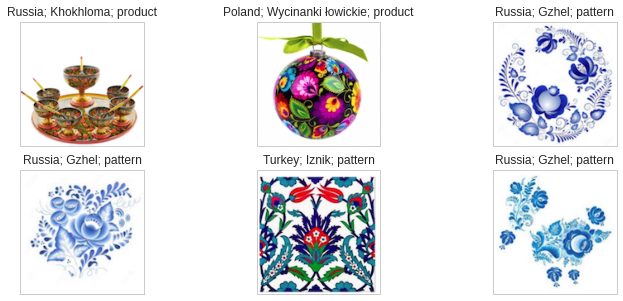

In [9]:
images=images/255
fig=pl.figure(figsize=(12,5))
for i,idx in enumerate(n):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(images[idx])
    ax.set_title(data['country'][idx]+'; '+\
                 data['decor'][idx]+'; '+data['type'][idx])
pl.show()

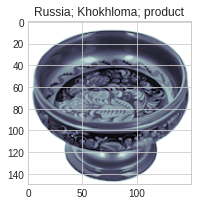

In [10]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
pl.figure(figsize=(3,3))
n=np.random.choice(484,size=1,replace=False)[0]
pl.imshow(images[n])
pl.title(data['country'][n]+'; '+\
         data['decor'][n]+'; '+data['type'][n])
pl.imshow(gray_images[n],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [11]:
ccountries,cdecors,ctypes=\
ohe(countries),ohe(decors),ohe(types)
ctargets=np.concatenate((ccountries,cdecors),axis=1)
ctargets=np.concatenate((ctargets,ctypes),axis=1)
pd.DataFrame([images.shape,gray_images.shape,
              ccountries.shape,cdecors.shape,
              ctypes.shape,ctargets.shape])

,0,1,2,3
0,485,150,150.0,3.0
1,485,150,150.0,1.0
2,485,4,NaN,NaN
3,485,7,NaN,NaN
4,485,2,NaN,NaN
5,485,13,NaN,NaN


In [12]:
# Color Images / Countries 
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,ccountries)
# Grayscaled Images / Countries 
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,ccountries)
# Color Images / Decors 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cdecors)
# Grayscaled Images / Decors 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cdecors)
# Color Images / Multi-Label Targets
x_train5,x_valid5,x_test5,\
y_train5,y_valid5,y_test5=tts(images,ctargets)
# Grayscaled Images / Multi-Label Targets 
x_train6,x_valid6,x_test6,\
y_train6,y_valid6,y_test6=tts(gray_images,ctargets)
sh=[el.shape for el in \
[x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1,
 x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train5,y_train5,x_valid5,y_valid5,x_test5,y_test5]]
sh2=[el.shape for el in \
[x_train2,y_train2,x_valid2,y_valid2,x_test2,y_test2,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4,
 x_train6,y_train6,x_valid6,y_valid6,x_test6,y_test6]]
pd.DataFrame([sh,sh2]).T

,0,1
0,"(388, 150, 150, 3)","(388, 150, 150, 1)"
1,"(388, 4)","(388, 4)"
2,"(48, 150, 150, 3)","(48, 150, 150, 1)"
3,"(48, 4)","(48, 4)"
4,"(49, 150, 150, 3)","(49, 150, 150, 1)"
5,"(49, 4)","(49, 4)"
6,"(388, 150, 150, 3)","(388, 150, 150, 1)"
7,"(388, 7)","(388, 7)"
8,"(48, 150, 150, 3)","(48, 150, 150, 1)"
9,"(48, 7)","(48, 7)"


In [0]:
y_train5_list=[y_train5[:,:i4],y_train5[:,i4:i11], y_train5[:,i11:]]
y_test5_list=[y_test5[:,:i4],y_test5[:,i4:i11], y_test5[:,i11:]]
y_valid5_list=[y_valid5[:,:i4],y_valid5[:,i4:i11], y_valid5[:,i11:]]
y_train6_list=[y_train6[:,:i4],y_train6[:,i4:i11], y_train6[:,i11:]]
y_test6_list=[y_test6[:,:i4],y_test6[:,i4:i11], y_test6[:,i11:]]
y_valid6_list=[y_valid6[:,:i4],y_valid6[:,i4:i11], y_valid6[:,i11:]]

 ## ✒️&nbsp;Step 2. One-Label Classification Models

In [14]:
# Color Images / Countries
def model():
    model=Sequential()
    model.add(Conv2D(i32,(i5,i5),padding='same',
                     input_shape=x_train1.shape[i1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i96,(i5,i5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))   
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i512,activation='relu'))
    model.add(Dropout(dr25))    
    model.add(Dense(i4))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
model=model()    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [15]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=model.fit(x_train1,y_train1,epochs=i32,
                  batch_size=i16,verbose=i2,
                  validation_data=(x_valid1,y_valid1),
                  callbacks=[checkpointer,lr_reduction])


Train on 388 samples, validate on 48 samples
Epoch 1/32
 - 7s - loss: 1.1785 - accuracy: 0.5361 - val_loss: 1.2306 - val_accuracy: 0.5417

Epoch 00001: val_loss improved from inf to 1.23057, saving model to weights.decor.hdf5
Epoch 2/32
 - 0s - loss: 1.0091 - accuracy: 0.6031 - val_loss: 1.2705 - val_accuracy: 0.5417

Epoch 00002: val_loss did not improve from 1.23057
Epoch 3/32
 - 0s - loss: 0.8667 - accuracy: 0.6392 - val_loss: 1.0521 - val_accuracy: 0.5417

Epoch 00003: val_loss improved from 1.23057 to 1.05213, saving model to weights.decor.hdf5
Epoch 4/32
 - 0s - loss: 0.7090 - accuracy: 0.7088 - val_loss: 0.9700 - val_accuracy: 0.5625

Epoch 00004: val_loss improved from 1.05213 to 0.97004, saving model to weights.decor.hdf5
Epoch 5/32
 - 0s - loss: 0.7433 - accuracy: 0.7062 - val_loss: 0.6918 - val_accuracy: 0.6875

Epoch 00005: val_loss improved from 0.97004 to 0.69176, saving model to weights.decor.hdf5
Epoch 6/32
 - 0s - loss: 0.6076 - accuracy: 0.7397 - val_loss: 0.5255 - v

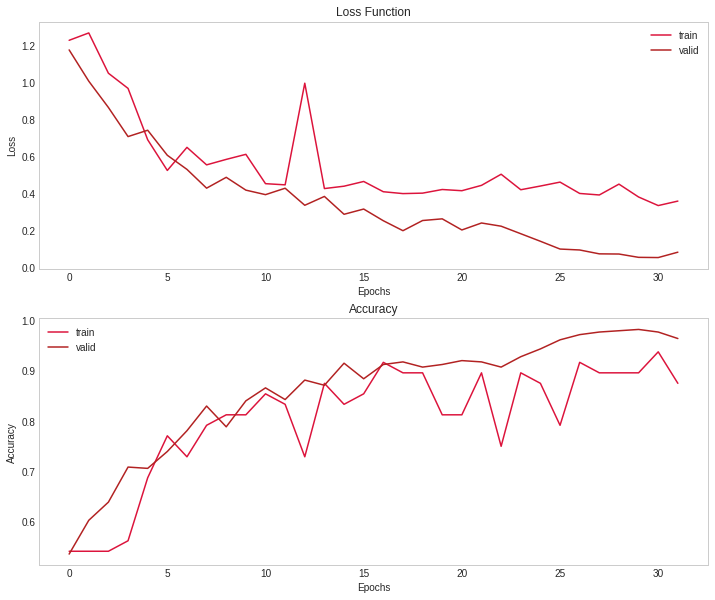

49/49 [==============================] - 0s 2ms/step


[0.40816558867084735, 0.8979591727256775]

In [16]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

In [0]:
# Color Images / Decors
def model(leaky_alpha):
    model=Sequential()
    model.add(Conv2D(i32,(i5,i5),padding='same', 
                     input_shape=x_train3.shape[i1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i96,(i5,i5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))   
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(i512))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dropout(dr25))     
    model.add(Dense(i7))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
model=model(float(.005))   

In [18]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=model.fit(x_train3,y_train3, 
                  epochs=i48,batch_size=i16,verbose=i2,
                  validation_data=(x_valid3,y_valid3),
                  callbacks=[checkpointer,lr_reduction])

Train on 388 samples, validate on 48 samples
Epoch 1/48
 - 1s - loss: 1.7751 - accuracy: 0.3273 - val_loss: 1.7739 - val_accuracy: 0.2917

Epoch 00001: val_loss improved from inf to 1.77391, saving model to weights.decor.hdf5
Epoch 2/48
 - 0s - loss: 1.4032 - accuracy: 0.4278 - val_loss: 1.3001 - val_accuracy: 0.5208

Epoch 00002: val_loss improved from 1.77391 to 1.30006, saving model to weights.decor.hdf5
Epoch 3/48
 - 0s - loss: 1.1262 - accuracy: 0.5644 - val_loss: 0.9642 - val_accuracy: 0.6250

Epoch 00003: val_loss improved from 1.30006 to 0.96422, saving model to weights.decor.hdf5
Epoch 4/48
 - 0s - loss: 1.0130 - accuracy: 0.6289 - val_loss: 1.0632 - val_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.96422
Epoch 5/48
 - 0s - loss: 0.8583 - accuracy: 0.6572 - val_loss: 1.3198 - val_accuracy: 0.5000

Epoch 00005: val_loss did not improve from 0.96422
Epoch 6/48
 - 0s - loss: 0.7260 - accuracy: 0.7320 - val_loss: 0.7468 - val_accuracy: 0.7708

Epoch 00006: val_los

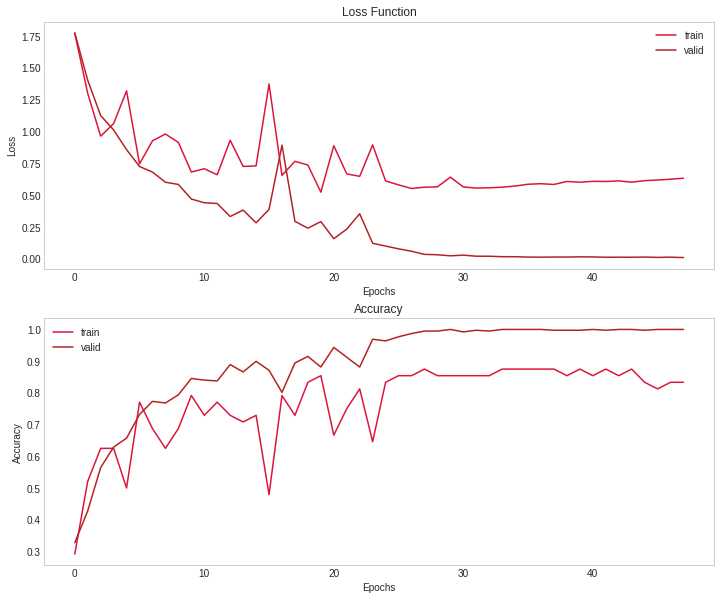

49/49 [==============================] - 0s 452us/step


[0.5615860783323949, 0.8163265585899353]

In [19]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test3,y_test3)

In [0]:
# Grayscaled Images / Countries
def gray_model():
    model=Sequential()
    model.add(Conv2D(i16,(i5,i5),padding='same', 
                     input_shape=x_train2.shape[i1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i128,(i5,i5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))   
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i512,activation='tanh'))
    model.add(Dropout(dr25))
    model.add(Dense(i4))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])
    return model
gray_model=gray_model()   

In [21]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=gray_model.fit(x_train2,y_train2, 
                       epochs=i64,batch_size=i16,verbose=i2,
                       validation_data=(x_valid2,y_valid2),
                       callbacks=[checkpointer,lr_reduction])

Train on 388 samples, validate on 48 samples
Epoch 1/64
 - 1s - loss: 1.1456 - accuracy: 0.5696 - val_loss: 1.2892 - val_accuracy: 0.5417

Epoch 00001: val_loss improved from inf to 1.28918, saving model to weights.decor.hdf5
Epoch 2/64
 - 0s - loss: 1.1040 - accuracy: 0.5876 - val_loss: 1.3100 - val_accuracy: 0.4583

Epoch 00002: val_loss did not improve from 1.28918
Epoch 3/64
 - 0s - loss: 1.0853 - accuracy: 0.5876 - val_loss: 1.3971 - val_accuracy: 0.0625

Epoch 00003: val_loss did not improve from 1.28918
Epoch 4/64
 - 0s - loss: 1.0858 - accuracy: 0.5851 - val_loss: 1.3718 - val_accuracy: 0.3542

Epoch 00004: val_loss did not improve from 1.28918
Epoch 5/64
 - 0s - loss: 1.0952 - accuracy: 0.5825 - val_loss: 1.2541 - val_accuracy: 0.5417

Epoch 00005: val_loss improved from 1.28918 to 1.25414, saving model to weights.decor.hdf5
Epoch 6/64
 - 0s - loss: 1.0511 - accuracy: 0.5851 - val_loss: 1.3949 - val_accuracy: 0.2500

Epoch 00006: val_loss did not improve from 1.25414
Epoch 7/6

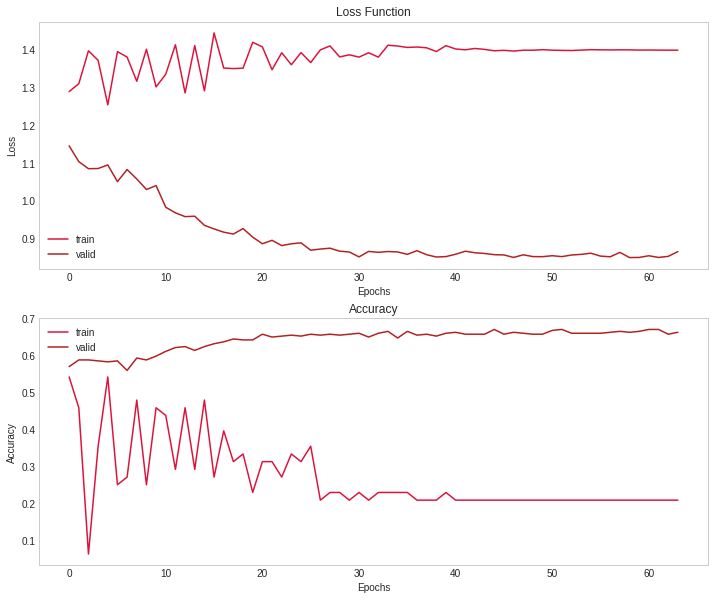

49/49 [==============================] - 0s 1ms/step


[1.3031827916904373, 0.44897958636283875]

In [22]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test2,y_test2)

In [0]:
# Grayscaled Images / Decors
def gray_model(leaky_alpha):
    model=Sequential()
    model.add(Conv2D(i16,(i5,i5),padding='same', 
                     input_shape=x_train4.shape[i1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i128,(i5,i5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))  
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i512, activation='tanh'))
    model.add(Dropout(dr25))   
    model.add(Dense(i7))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])
    return model
gray_model=gray_model(float(.01))

In [24]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=gray_model.fit(x_train4,y_train4, 
                       epochs=i64,batch_size=i16,verbose=i2,
                       validation_data=(x_valid4,y_valid4),
                       callbacks=[checkpointer,lr_reduction])

Train on 388 samples, validate on 48 samples
Epoch 1/64
 - 1s - loss: 1.9850 - accuracy: 0.1624 - val_loss: 1.9182 - val_accuracy: 0.1875

Epoch 00001: val_loss improved from inf to 1.91823, saving model to weights.decor.hdf5
Epoch 2/64
 - 0s - loss: 1.9011 - accuracy: 0.1933 - val_loss: 1.9114 - val_accuracy: 0.1667

Epoch 00002: val_loss improved from 1.91823 to 1.91136, saving model to weights.decor.hdf5
Epoch 3/64
 - 0s - loss: 1.8739 - accuracy: 0.2242 - val_loss: 2.0180 - val_accuracy: 0.0417

Epoch 00003: val_loss did not improve from 1.91136
Epoch 4/64
 - 0s - loss: 1.8386 - accuracy: 0.2216 - val_loss: 1.9087 - val_accuracy: 0.2083

Epoch 00004: val_loss improved from 1.91136 to 1.90869, saving model to weights.decor.hdf5
Epoch 5/64
 - 0s - loss: 1.8258 - accuracy: 0.2397 - val_loss: 1.9405 - val_accuracy: 0.1458

Epoch 00005: val_loss did not improve from 1.90869
Epoch 6/64
 - 0s - loss: 1.7790 - accuracy: 0.2371 - val_loss: 2.0654 - val_accuracy: 0.0625

Epoch 00006: val_los

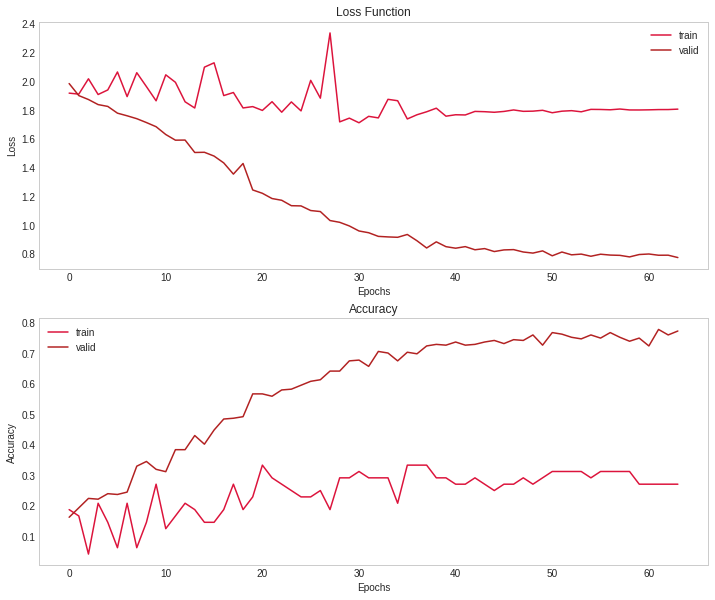

49/49 [==============================] - 0s 442us/step


[1.5432286189526927, 0.36734694242477417]

In [25]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test4,y_test4)

## ✒️&nbsp;Step 3. Multi-Label Classification Models

In [0]:
def multi_model(leaky_alpha):    
    model_input=Input(shape=x_train5.shape[i1:])
    x=BatchNormalization()(model_input)
    x=Conv2D(i32,(i5,i5),padding='same')(model_input)
    x=LeakyReLU(alpha=leaky_alpha)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)   
    x=Conv2D(i128,(i5,i5),padding='same')(x)
    x=LeakyReLU(alpha=leaky_alpha)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)            
    x=GlobalMaxPooling2D()(x)  
    x=Dense(i512)(x) 
    x=LeakyReLU(alpha=leaky_alpha)(x)
    x=Dropout(dr25)(x)    
    y1=Dense(i4,activation='softmax')(x)
    y2=Dense(i7,activation='softmax')(x)
    y3=Dense(i2,activation='softmax')(x)   
    model=Model(inputs=model_input,outputs=[y1,y2,y3])
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
multi_model=multi_model(float(.005))

In [27]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=multi_model.fit(x_train5,y_train5_list, 
                        epochs=i48,batch_size=i16,verbose=i2,
                        validation_data=(x_valid5,y_valid5_list),
                        callbacks=[checkpointer,lr_reduction])

Train on 388 samples, validate on 48 samples
Epoch 1/48
 - 1s - loss: 3.7680 - dense_10_loss: 1.1513 - dense_11_loss: 1.8822 - dense_12_loss: 0.7201 - dense_10_accuracy: 0.5541 - dense_11_accuracy: 0.2345 - dense_12_accuracy: 0.5026 - val_loss: 3.6807 - val_dense_10_loss: 1.1591 - val_dense_11_loss: 1.8086 - val_dense_12_loss: 0.7131 - val_dense_10_accuracy: 0.5417 - val_dense_11_accuracy: 0.3750 - val_dense_12_accuracy: 0.5208

Epoch 00001: val_loss improved from inf to 3.68073, saving model to weights.decor.hdf5
Epoch 2/48
 - 0s - loss: 3.2440 - dense_10_loss: 1.0137 - dense_11_loss: 1.4991 - dense_12_loss: 0.7127 - dense_10_accuracy: 0.6134 - dense_11_accuracy: 0.4459 - dense_12_accuracy: 0.5541 - val_loss: 3.0333 - val_dense_10_loss: 0.8925 - val_dense_11_loss: 1.4301 - val_dense_12_loss: 0.7107 - val_dense_10_accuracy: 0.5833 - val_dense_11_accuracy: 0.4375 - val_dense_12_accuracy: 0.4792

Epoch 00002: val_loss improved from 3.68073 to 3.03329, saving model to weights.decor.hdf5
E

In [28]:
multi_model.load_weights(fw)
multi_scores=multi_model.evaluate(x_test5,y_test5_list,verbose=0)
print("Scores: \n" ,(multi_scores))
print("Country label. Accuracy: %.2f%%"%(multi_scores[i4]*100))
print("Decor label. Accuracy: %.2f%%"%(multi_scores[i5]*100))
print("Type label. Accuracy: %.2f%%"%(multi_scores[i6]*100))

Scores: 
 [1.3616378161371971, 0.6203408241271973, 0.6366446614265442, 0.32458388805389404, 0.8571428656578064, 0.8571428656578064, 0.8367347121238708]
Country label. Accuracy: 85.71%
Decor label. Accuracy: 85.71%
Type label. Accuracy: 83.67%


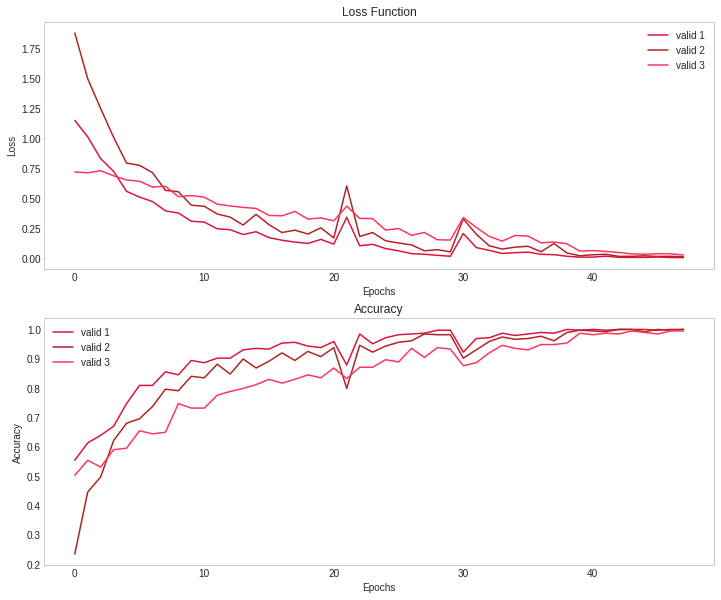

In [29]:
history_plot2(history)

In [0]:
def gray_multi_model(leaky_alpha):    
    model_input=Input(shape=x_train6.shape[i1:])
    x=BatchNormalization()(model_input)
    x=Conv2D(i32,(i5,i5), padding='same')(model_input)
    x=LeakyReLU(alpha=leaky_alpha)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)  
    x=Conv2D(i256,(i5,i5),padding='same')(x)
    x=LeakyReLU(alpha=leaky_alpha)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)             
    x=GlobalMaxPooling2D()(x) 
    x=Dense(i2048)(x) 
    x=LeakyReLU(alpha=leaky_alpha)(x)
    x=Dropout(dr25)(x)   
    y1=Dense(i4,activation='softmax')(x)
    y2=Dense(i7,activation='softmax')(x)
    y3=Dense(i2,activation='softmax')(x) 
    model=Model(inputs=model_input,outputs=[y1,y2,y3])   
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])  
    return model
gray_multi_model=gray_multi_model(float(.01))

In [31]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=gray_multi_model.fit(x_train6,y_train6_list,
                             epochs=i48,batch_size=i16,verbose=i2,
                             validation_data=(x_valid6,y_valid6_list),
                             callbacks=[checkpointer,lr_reduction])

Train on 388 samples, validate on 48 samples
Epoch 1/48
 - 1s - loss: 3.8416 - dense_14_loss: 1.1560 - dense_15_loss: 1.9555 - dense_16_loss: 0.7304 - dense_14_accuracy: 0.5722 - dense_15_accuracy: 0.1933 - dense_16_accuracy: 0.4691 - val_loss: 3.8306 - val_dense_14_loss: 1.2142 - val_dense_15_loss: 1.9244 - val_dense_16_loss: 0.6920 - val_dense_14_accuracy: 0.5417 - val_dense_15_accuracy: 0.1875 - val_dense_16_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 3.83057, saving model to weights.decor.hdf5
Epoch 2/48
 - 1s - loss: 3.7212 - dense_14_loss: 1.1009 - dense_15_loss: 1.9080 - dense_16_loss: 0.7037 - dense_14_accuracy: 0.5876 - dense_15_accuracy: 0.2113 - dense_16_accuracy: 0.4897 - val_loss: 3.7331 - val_dense_14_loss: 1.1350 - val_dense_15_loss: 1.9082 - val_dense_16_loss: 0.6900 - val_dense_14_accuracy: 0.5417 - val_dense_15_accuracy: 0.1667 - val_dense_16_accuracy: 0.5833

Epoch 00002: val_loss improved from 3.83057 to 3.73309, saving model to weights.decor.hdf5
E

In [32]:
gray_multi_model.load_weights(fw)
gray_multi_scores=\
gray_multi_model.evaluate(x_test6,y_test6_list,verbose=i0)
print("Scores: \n" ,(gray_multi_scores))
print("Country label. Accuracy: %.2f%%"%(gray_multi_scores[4]*100))
print("Decor label. Accuracy: %.2f%%"%(gray_multi_scores[5]*100))
print("Type label. Accuracy: %.2f%%"%(gray_multi_scores[6]*100))

Scores: 
 [3.2886844459845097, 1.2474167346954346, 1.7214661836624146, 0.38341546058654785, 0.5918367505073547, 0.3877550959587097, 0.8775510191917419]
Country label. Accuracy: 59.18%
Decor label. Accuracy: 38.78%
Type label. Accuracy: 87.76%


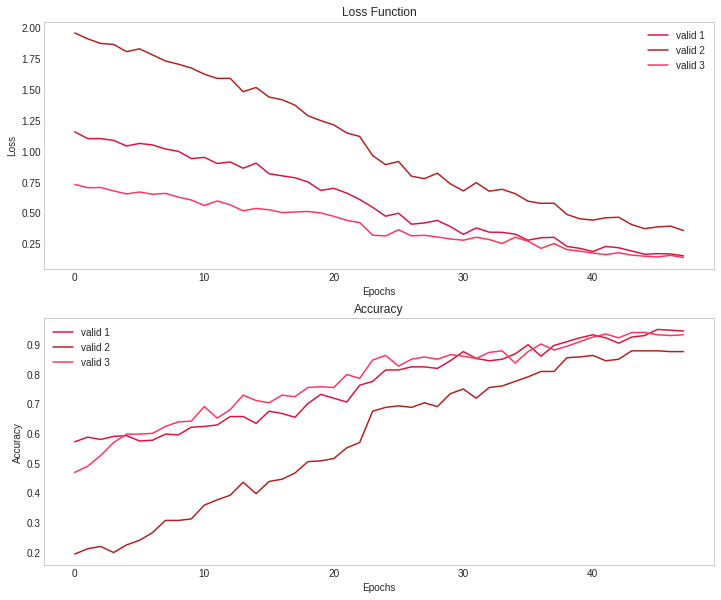

In [33]:
history_plot2(history)

## ✒️  Step 4. Keras Applications

In [0]:
from keras.applications.resnet50 import \
ResNet50,preprocess_input as rn50pi
from keras.applications.inception_v3 import \
InceptionV3,preprocess_input as iv3pi
from keras.applications.xception \
import Xception,preprocess_input as xpi
from keras.applications.inception_resnet_v2 import \
InceptionResNetV2,preprocess_input as iv2pi
import scipy; from scipy import misc

In [0]:
resize_x_train3=np.array([resize(x_train3[i],(180,180,3)) 
                          for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid3=np.array([resize(x_valid3[i],(180,180,3)) 
                          for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test3=np.array([resize(x_test3[i],(180,180,3)) 
                          for i in range(0,len(x_test3))]).astype('float32')
#x_train_bn3=rn50pi(resize_x_train3)
#x_valid_bn3=rn50pi(resize_x_valid3)
#x_test_bn3=rn50pi(resize_x_test3)
resnet50base_model=\
ResNet50(weights='imagenet',include_top=False)
x_train_bn3=resnet50base_model.predict(resize_x_train3)
x_valid_bn3=resnet50base_model.predict(resize_x_valid3)
x_test_bn3=resnet50base_model.predict(resize_x_test3)

In [0]:
sh=x_train_bn3.shape[1:]
def resnet50_model():
    model=Sequential()
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7, activation='softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
resnet50_model=resnet50_model()

In [53]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=\
resnet50_model.fit(x_train_bn3,y_train3,
                   validation_data=(x_valid_bn3,y_valid3),
                   epochs=100,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 1s - loss: 2.7091 - accuracy: 0.1959 - val_loss: 3.1815 - val_accuracy: 0.1875

Epoch 00001: val_loss improved from inf to 3.18147, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 2.7198 - accuracy: 0.1881 - val_loss: 2.0391 - val_accuracy: 0.1458

Epoch 00002: val_loss improved from 3.18147 to 2.03913, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 2.1808 - accuracy: 0.1392 - val_loss: 1.9223 - val_accuracy: 0.1875

Epoch 00003: val_loss improved from 2.03913 to 1.92228, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 1.9313 - accuracy: 0.2526 - val_loss: 1.8906 - val_accuracy: 0.1875

Epoch 00004: val_loss improved from 1.92228 to 1.89060, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 1.9184 - accuracy: 0.2294 - val_loss: 1.8712 - val_accuracy: 0.1667

Epoch 00005: val_loss improved from 1.89060 to 1.87119, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 1.8

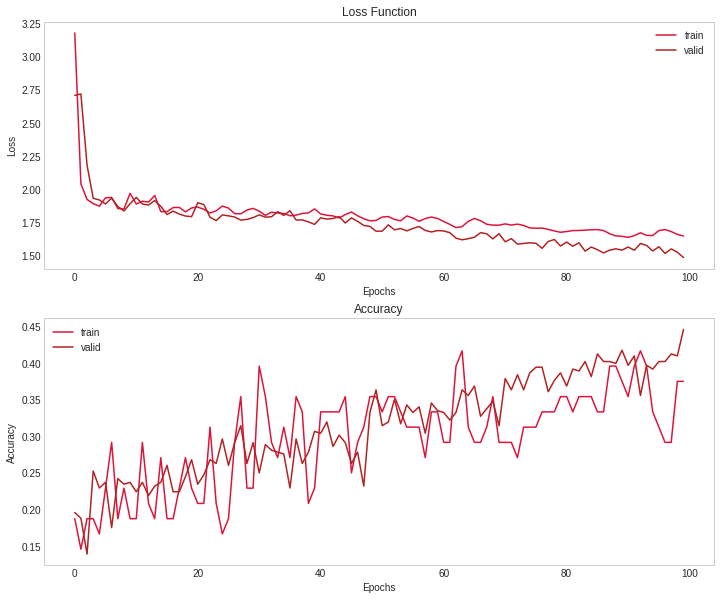

49/49 [==============================] - 0s 419us/step
Accuracy: 38.78%


[1.5712972222542276, 0.3877550959587097]

In [54]:
history_plot(history)
resnet50_model.load_weights(fw)
resnet50_scores=resnet50_model.evaluate(x_test_bn3,y_test3)
print("Accuracy: %.2f%%"%(resnet50_scores[1]*100))
resnet50_scores